In [3]:
from __future__ import print_function
import numpy as np
import pandas as pd


from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression as logreg

import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma

from sklearn.feature_selection import chi2

import scipy as sp
from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import pylab as pl
%pylab inline

import geopandas as gp

Populating the interactive namespace from numpy and matplotlib


In [4]:
def filterPerfectCorrelation(df):
    cols = df.columns
    removeCols = []
    for i in range(len(cols)-1):
        for j in range(i+1,len(cols)):
            cor = stats.pearsonr(df[cols[i]].values, df[cols[j]].values)[0]
            if cor >=1 or cor <=-1:
                removeCols.append(cols[i])
    return df[[c for c in cols if c not in removeCols]]
        

In [5]:
def bolleanToNumeric(df):
    for c in df.columns:
        if df[c].dtype == 'bool':
            df[c] = df[c].astype(int)
    return df

In [6]:
# remove class imballance by sampling from majority class
def classImballanceDownSample(df,ycol):
    df = df.copy()
    valueCount = df[ycol].value_counts()
    print("Before Class Imballance Treatment: ")
    print(valueCount)
    classes = valueCount.index
    counts = valueCount.values
    minClassSize = np.min(counts)
    for clas in classes:
        df1 = df[df[ycol]==clas]
        df2 = df[df[ycol]!=clas]
        
        df1 = df1.sample(n=minClassSize, random_state=50)
        df = df1.append(df2)
    #shuffling the dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    print("After Class Imballance Treatment: ")
    print(df[ycol].value_counts())
    return df  

In [7]:
# remove class imballance by up sampling minority classes
def classImballanceUpSample(df,ycol):
    df = df.copy()
    valueCount = df[ycol].value_counts()
    print("Before Class Imballance Treatment: ")
    print(valueCount)
    classes = valueCount.index
    counts = valueCount.values
    maxClassSize = np.max(counts).astype(float)
    fractions = maxClassSize / counts
    for clas,f in zip(classes,fractions):
        df1 = df[df[ycol]==clas]
        df2 = df[df[ycol]!=clas]
        
        df1 = df1.sample(frac=f, replace=True, random_state=50)
        df = df1.append(df2)
    #shuffling the dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    print("After Class Imballance Treatment: ")
    print(df[ycol].value_counts())
    return df  

In [8]:
# model that trains a default random forest and prints the report
def getModel(df,label, ballanceClasses=None, rfcBalance = None):
    
    xcols = [c for c in df.columns if c != label]
    ycols = [label]
    print("Predictors: ",len(xcols))
    print("label: ",ycols[0])
    
#     if ballanceClasses != None:
#         df = ballanceClasses(df, ycols[0])
        
    X = df[xcols]
    Y = df[ycols]
    
    #X = labelEncodeCategoricalFeatures(X)
    #print("Label Encoding.")
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42, shuffle=True)
    print("Train Test Split:")
    print(np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape)
    
    if ballanceClasses != None:
        dfTrain = X_train
        dfTrain['label'] = y_train
        dfTrain = ballanceClasses(dfTrain,'label')
        X_train = dfTrain[ [c for c in dfTrain.columns if c not in 'label'] ]
        y_train = dfTrain['label']
    
    #print("Checking if sampling worked:")
    #print(y_train.value_counts())
    #print()
    
    if rfcBalance == None:
        clf = rfc()
    else:
        clf = rfc(class_weight = rfcBalance)
        print(clf)
    
    #clf = rfc()
    clf.fit(X_train, y_train.values.ravel())
    y_pred = clf.predict(X_test)
    print("OS Accuracy : ", np.sum(y_test[ycols[0]].values==y_pred).astype(float)/len(y_test) )
    print("IS Accuracy : ", np.sum(y_train[ycols[0]]==clf.predict(X_train)).astype(float)/len(y_train) )
    
    print(classification_report(y_test[ycols[0]].values, y_pred))
    
    
    for th in [0.05,0.1,0.2,0.4,0.5,0.6,0.8]:
        y_pred = clf.predict_proba(X_test)[:,1] > th
        print('TH: ',th)
        print("Accuracy : ", np.sum(y_test[ycols[0]].values==y_pred).astype(float)/len(y_test) )
        print(classification_report(y_test[ycols[0]].values, y_pred))
        print()
    

In [9]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
def labelEncodeCategoricalFeatures(DF):
    df = DF.copy()
    for c in df.columns:
        if df[c].dtype.name == 'object':
            df[c] = labelencoder.fit_transform(df[c])
    return df

### Load Data

In [10]:
cleandf = pd.read_csv('cleanDataSmoke.csv')
cleandf.shape

(427526, 30)

In [11]:
cleandf.head()

,ads18_frequentHealthIssue,ads18_highBP,ads18_highChl,ads18_unknownChl,ads18_asthma,ads18_formerasthma,ads18_white,ads18_weight,ads18_obese,ads18_havechild,...,ads18_healthCov,ads18_older40,ads18_age18_25,ads18_age25_30,ads18_seatbelt,ads18_veteran,ads18_affordDoc,ads18_stroke,ads18_state,label
0,False,True,True,False,False,False,True,7348.0,True,False,...,True,True,False,False,True,True,True,False,Alabama,No
1,False,True,False,False,False,False,True,9571.0,True,False,...,True,True,False,False,True,False,True,False,Alabama,No
2,False,False,True,False,False,False,True,8845.0,True,False,...,True,True,False,False,True,False,True,False,Alabama,No
3,False,True,True,False,False,False,True,7711.0,True,False,...,True,True,False,False,False,False,True,False,Alabama,No
4,True,False,False,False,True,False,True,6350.0,False,False,...,True,True,False,False,False,False,True,False,Alabama,No


In [12]:
print("Records: ",len(cleandf))
cleandf = cleandf.dropna()
print("Records after cleaning Nan: ",len(cleandf))

Records:  427526
Records after cleaning Nan:  384321


In [13]:
cleandf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384321 entries, 0 to 427525
Data columns (total 30 columns):
ads18_frequentHealthIssue    384321 non-null bool
ads18_highBP                 384321 non-null bool
ads18_highChl                384321 non-null bool
ads18_unknownChl             384321 non-null bool
ads18_asthma                 384321 non-null bool
ads18_formerasthma           384321 non-null bool
ads18_white                  384321 non-null bool
ads18_weight                 384321 non-null float64
ads18_obese                  384321 non-null bool
ads18_havechild              384321 non-null bool
ads18_edu                    384321 non-null int64
ads18_income                 384321 non-null int64
ads18_drinkdaily             384321 non-null bool
ads18_drinkbinge             384321 non-null bool
ads18_fruitIntake            384321 non-null float64
ads18_vegIntake              384321 non-null float64
ads18_potatoIntake           384321 non-null float64
ads18_exercise           

In [14]:
cleandf['label'] = cleandf.label == 'Yes'
cleandf.label.value_counts()

False    327634
True      56687
Name: label, dtype: int64

In [15]:
#Pick the Cigeratte tax rate in 2017
tax = pd.read_csv('Tax.csv')
tax17 = tax[tax['Year']==2017]
tax17.head()
tax_value = tax17[tax17['ProvisionDesc'] == 'Cigarette Tax ($ per pack)'].sort_values('LocationDesc')
tax_value = tax_value.groupby('LocationDesc').max()
tax_value = tax_value[['ProvisionAltValue']]
tax_value.rename(columns={'ProvisionAltValue':'Cigarette_tax'}, inplace=True)
tax_value.reset_index(inplace=True)
print(tax_value.shape)
tax_value.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(58, 2)


,LocationDesc,Cigarette_tax
0,Alabama,0.675
1,Alaska,2.000
2,American Samoa,6.000
3,Arizona,2.000
4,Arkansas,1.150


In [16]:
cleandf = cleandf.merge(tax_value, left_on='ads18_state', right_on='LocationDesc', how='left')
cleandf.drop(columns = ['LocationDesc'] , inplace=True )

In [17]:
cleandf.shape

(384321, 31)

In [18]:
mormondf = pd.read_csv('mormon.csv',skiprows=1)
mormondf.columns = ['MState','mormon']
print(mormondf.shape)
mormondf.head()

(51, 2)


,MState,mormon
0,Utah,100
1,Idaho,40
2,Wyoming,22
3,Arizona,15
4,Alaska,13


In [19]:
cleandf = cleandf.merge(mormondf, left_on='ads18_state', right_on='MState', how='left')
cleandf.drop(columns = ['MState'] , inplace=True )

In [20]:
cleandf['mormon'].fillna(np.mean(cleandf['mormon']), inplace=True)

In [21]:
pricedf = pd.read_csv('SmokingStatesData.csv')
print(pricedf.shape)
pricedf= pricedf[['State','Price']]
#pricedf['ExciseTax'] = pricedf.ExciseTax.apply(lambda x: float(x.replace('$','')) )
pricedf['Price'] = pricedf.Price.apply(lambda x: float(x.replace('$','')) )
pricedf.head(3)

(51, 4)


,State,Price
0,Missouri,4.38
1,Virginia,4.78
2,North Dakota,4.82


In [22]:
cleandf = cleandf.merge(pricedf, left_on='ads18_state', right_on='State', how='left')
cleandf.drop(columns = ['State'] , inplace=True )

In [23]:
#cleandf['ExciseTax'].fillna(np.mean(cleandf['ExciseTax']), inplace=True)
cleandf['Price'].fillna(np.mean(cleandf['Price']), inplace=True)

In [24]:
cleandf['Price'] = cleandf.Price / cleandf.ads18_income

In [25]:
stateSmokedf = cleandf[['ads18_state','label']].groupby('ads18_state').mean().reset_index()
stateSmokedf.columns = ['ads18_state','stateSmoke']
print(stateSmokedf.shape)

(53, 2)


In [26]:
print(cleandf.shape)
cleandf = cleandf.merge(stateSmokedf, left_on='ads18_state', right_on='ads18_state', how='left')
cleandf.shape
#cleandf.drop(columns = ['State'] , inplace=True )

(384321, 33)


(384321, 34)

## Model with out imballance treatment

In [27]:
Y= cleandf['label']
#not in ['label','ads18_state']
X = cleandf[[c for c in cleandf.columns if c not in ['label','ads18_state']]]
print("columns :", len(X.columns))
X = filterPerfectCorrelation(X)
X = bolleanToNumeric(X)
print("Uncorrelated columns :", len(X.columns))
logit_mod = sma.Logit(Y, X, method='bfgs').fit()
print(logit_mod.summary())

columns : 32
Uncorrelated columns : 32
Optimization terminated successfully.
         Current function value: 0.365413
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:               384321
Model:                          Logit   Df Residuals:                   384289
Method:                           MLE   Df Model:                           31
Date:                Mon, 17 Dec 2018   Pseudo R-squ.:                  0.1265
Time:                        22:58:04   Log-Likelihood:            -1.4044e+05
converged:                       True   LL-Null:                   -1.6078e+05
                                        LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
ads18_frequentHealthIssue     0.4234   

In [28]:
result = pd.concat([logit_mod.params, logit_mod.pvalues], axis=1).reset_index() 
result.columns = ['var','coef','pval']
result

,var,coef,pval
0,ads18_frequentHealthIssue,0.423425,2.220830e-225
1,ads18_highBP,-0.093177,2.087807e-16
2,ads18_highChl,0.007304,5.263319e-01
3,ads18_unknownChl,0.270725,5.546161e-71
4,ads18_asthma,0.216247,1.722392e-44
5,ads18_formerasthma,-0.174329,1.999574e-10
6,ads18_white,0.237870,1.206364e-87
7,ads18_weight,-0.000029,3.742243e-22
8,ads18_obese,-0.278218,2.038014e-101
9,ads18_havechild,0.119475,5.447246e-24


AUC:  0.7504270869661075


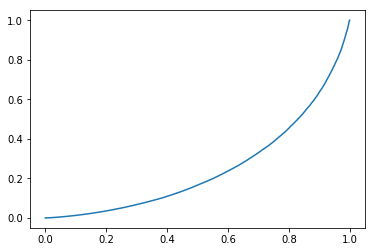

In [29]:
pred = logit_mod.predict() #> 0.5
fpr, tpr, thresholds = metrics.roc_curve(Y, pred)
print('AUC: ',metrics.auc(fpr, tpr))
pl.plot(tpr,fpr)

In [30]:
for th in [0.05,0.1,0.2,0.4,0.5,0.6,0.8]:
        print('TH: ',th)
        print("Accuracy : ", np.sum(Y==(pred > th)).astype(float)/len(Y) )
        print(classification_report(Y, pred > th))
        print()


TH:  0.05
Accuracy :  0.30217968833345044
             precision    recall  f1-score   support

      False       0.97      0.19      0.31    327634
       True       0.17      0.96      0.29     56687

avg / total       0.85      0.30      0.31    384321


TH:  0.1
Accuracy :  0.5599746045623321
             precision    recall  f1-score   support

      False       0.94      0.51      0.67    327634
       True       0.23      0.82      0.35     56687

avg / total       0.84      0.56      0.62    384321


TH:  0.2
Accuracy :  0.7766424421252026
             precision    recall  f1-score   support

      False       0.91      0.82      0.86    327634
       True       0.33      0.52      0.41     56687

avg / total       0.82      0.78      0.80    384321


TH:  0.4
Accuracy :  0.8537758800585968
             precision    recall  f1-score   support

      False       0.87      0.97      0.92    327634
       True       0.51      0.17      0.26     56687

avg / total       0.82      0

## DownSample

In [31]:
cleandfDn = classImballanceDownSample(cleandf, 'label')

Before Class Imballance Treatment: 
False    327634
True      56687
Name: label, dtype: int64
After Class Imballance Treatment: 
True     56687
False    56687
Name: label, dtype: int64


In [32]:
Y= cleandfDn['label']
X = cleandfDn[[c for c in cleandfDn.columns if c not in ['label','ads18_state'] ]]
print("columns :", len(X.columns))
X = filterPerfectCorrelation(X)
X = bolleanToNumeric(X)
print("Uncorrelated columns :", len(X.columns))

logit_mod = sma.Logit(Y, X, method='bfgs').fit()
print(logit_mod.summary())

columns : 32
Uncorrelated columns : 32
Optimization terminated successfully.
         Current function value: 0.598802
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:               113374
Model:                          Logit   Df Residuals:                   113342
Method:                           MLE   Df Model:                           31
Date:                Mon, 17 Dec 2018   Pseudo R-squ.:                  0.1361
Time:                        22:58:41   Log-Likelihood:                -67889.
converged:                       True   LL-Null:                       -78585.
                                        LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
ads18_frequentHealthIssue     0.4584   

In [33]:
resultds = pd.concat([logit_mod.params, logit_mod.pvalues], axis=1).reset_index() 
resultds.columns = ['var','coef','pval']
resultds

,var,coef,pval
0,ads18_frequentHealthIssue,0.458377,2.610920e-130
1,ads18_highBP,-0.094458,3.652829e-10
2,ads18_highChl,0.018436,2.303050e-01
3,ads18_unknownChl,0.304514,2.561817e-45
4,ads18_asthma,0.182263,4.617263e-17
5,ads18_formerasthma,-0.147663,9.422337e-05
6,ads18_white,0.149215,1.138367e-20
7,ads18_weight,0.000009,2.122150e-02
8,ads18_obese,-0.300555,9.211082e-65
9,ads18_havechild,0.141283,1.637896e-18


AUC:  0.744258739632


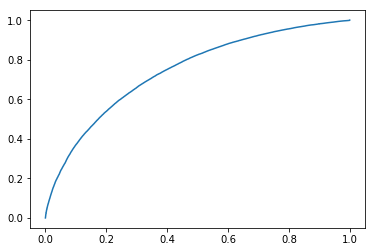

In [160]:
pred = logit_mod.predict() #> 0.5
fpr, tpr, thresholds = metrics.roc_curve(Y, pred)
print('AUC: ',metrics.auc(fpr, tpr))
pl.plot(fpr,tpr)

In [161]:
for th in [0.05,0.1,0.2,0.4,0.5,0.6,0.8]:
        print('TH: ',th)
        print("Accuracy : ", np.sum(Y==(pred > th)).astype(float)/len(Y) )
        print(classification_report(Y, pred > th))
        print()


TH:  0.05
Accuracy :  0.500167586925
              precision    recall  f1-score   support

       False       0.60      0.00      0.00     56687
        True       0.50      1.00      0.67     56687

   micro avg       0.50      0.50      0.50    113374
   macro avg       0.55      0.50      0.33    113374
weighted avg       0.55      0.50      0.33    113374


TH:  0.1
Accuracy :  0.502002222732
              precision    recall  f1-score   support

       False       0.80      0.01      0.01     56687
        True       0.50      1.00      0.67     56687

   micro avg       0.50      0.50      0.50    113374
   macro avg       0.65      0.50      0.34    113374
weighted avg       0.65      0.50      0.34    113374


TH:  0.2
Accuracy :  0.550073209025
              precision    recall  f1-score   support

       False       0.84      0.12      0.22     56687
        True       0.53      0.98      0.68     56687

   micro avg       0.55      0.55      0.55    113374
   macro avg     

### Residual Analysis

(array([  1310.,   9969.,  17493.,  18921.,   8989.,   6754.,  23449.,
         16812.,   8112.,   1565.]),
 array([-0.99999997, -0.80033824, -0.6006765 , -0.40101476, -0.20135303,
        -0.00169129,  0.19797045,  0.39763218,  0.59729392,  0.79695565,
         0.99661739]),
 <a list of 10 Patch objects>)

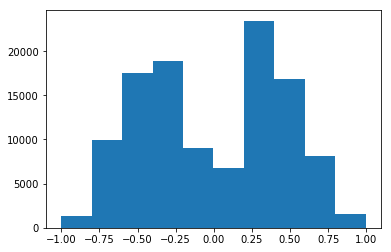

In [162]:
Yint = Y.astype(int)
error = pred - Yint
pl.hist(error)

In [163]:
fp = (~Y) & (pred>0.5)
fn = (Y) & (pred<=0.5)
tptn = Y ==  (pred<=0.5)

In [164]:
errordf = pd.DataFrame({'error':error, 'state':cleandfDn.ads18_state, 'fp':fp, 'fn':fn, 'tptn':tptn, 'pred':pred, 'truth':Y})

In [165]:
statesshp =  gp.GeoDataFrame.from_file('stateshp/cb_2017_us_state_5m.shp')
statesshp = statesshp.to_crs(epsg = 4326)

In [166]:
zip(sorted(statesshp.NAME),sorted(set(errordf.state)))

[(u'Alabama', 'Alabama'),
 (u'Alaska', 'Alaska'),
 (u'American Samoa', 'Arizona'),
 (u'Arizona', 'Arkansas'),
 (u'Arkansas', 'California'),
 (u'California', 'Colorado'),
 (u'Colorado', 'Connecticut'),
 (u'Commonwealth of the Northern Mariana Islands', 'Delaware'),
 (u'Connecticut', 'District of Columbia'),
 (u'Delaware', 'Florida'),
 (u'District of Columbia', 'Georgia'),
 (u'Florida', 'Guam'),
 (u'Georgia', 'Hawaii'),
 (u'Guam', 'Idaho'),
 (u'Hawaii', 'Illinois'),
 (u'Idaho', 'Indiana'),
 (u'Illinois', 'Iowa'),
 (u'Indiana', 'Kansas'),
 (u'Iowa', 'Kentucky'),
 (u'Kansas', 'Louisiana'),
 (u'Kentucky', 'Maine'),
 (u'Louisiana', 'Maryland'),
 (u'Maine', 'Massachusetts'),
 (u'Maryland', 'Michigan'),
 (u'Massachusetts', 'Minnesota'),
 (u'Michigan', 'Mississippi'),
 (u'Minnesota', 'Missouri'),
 (u'Mississippi', 'Montana'),
 (u'Missouri', 'Nebraska'),
 (u'Montana', 'Nevada'),
 (u'Nebraska', 'New Hampshire'),
 (u'Nevada', 'New Jersey'),
 (u'New Hampshire', 'New Mexico'),
 (u'New Jersey', 'New 

In [167]:
errordf = errordf.groupby('state').mean().reset_index()
errordf.shape

(53, 7)

(array([  3.,   4.,  13.,   9.,  10.,   6.,   4.,   1.,   1.,   2.]),
 array([-0.08166278, -0.06094893, -0.04023507, -0.01952121,  0.00119265,
         0.02190651,  0.04262037,  0.06333423,  0.08404809,  0.10476195,
         0.12547581]),
 <a list of 10 Patch objects>)

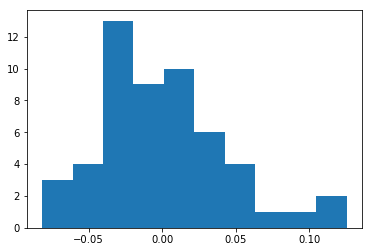

In [168]:
pl.hist(errordf.error)

In [169]:
statesshp.shape

(56, 10)

In [170]:
statesshp = statesshp.merge(errordf, left_on='NAME', right_on='state', how='left')

In [171]:
statesshp.shape

(56, 17)

(25, 50)

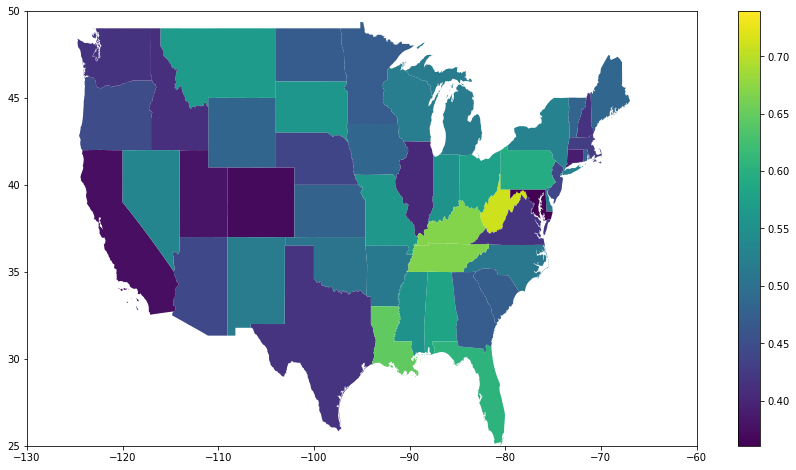

In [172]:
figure, ax = plt.subplots(figsize=(15, 8))
statesshp.plot(column='pred',ax=ax, legend=True)
plt.xlim((-130,-60))
plt.ylim((25,50))

(25, 50)

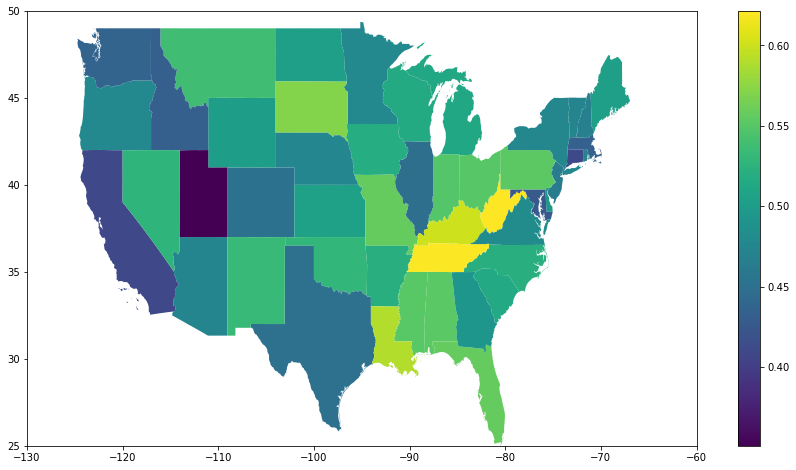

In [173]:
figure, ax = plt.subplots(figsize=(15, 8))
statesshp.plot(column='truth',ax=ax, legend=True)
plt.xlim((-130,-60))
plt.ylim((25,50))

(25, 50)

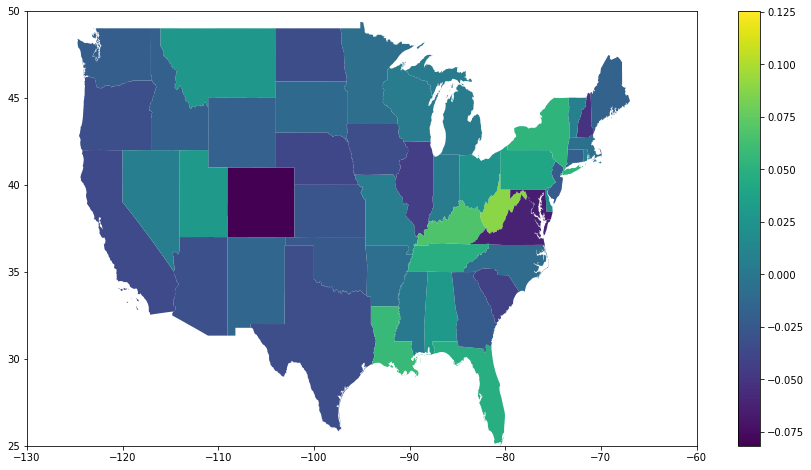

In [175]:
figure, ax = plt.subplots(figsize=(15, 8))
statesshp.plot(column='error',ax=ax, legend=True)
plt.xlim((-130,-60))
plt.ylim((25,50))

In [176]:
mormondf = pd.read_csv('mormon.csv',skiprows=1)
mormondf.columns = ['State','mormon']
print(mormondf.shape)
mormondf.head()

(51, 2)


,State,mormon
0,Utah,100
1,Idaho,40
2,Wyoming,22
3,Arizona,15
4,Alaska,13


In [ ]:
statesshp = statesshp.merge(mormondf, left_on='NAME', right_on='State', how='left')

In [ ]:
figure, ax = plt.subplots(figsize=(15, 8))
statesshp.plot(column='Cigarette_tax',ax=ax, legend=True)
plt.xlim((-130,-60))
plt.ylim((25,50))

In [ ]:
figure, ax = plt.subplots(figsize=(15, 8))
statesshp.plot(column='Cigarette_tax',ax=ax, legend=True)
plt.xlim((-130,-60))
plt.ylim((25,50))

In [ ]:
statesshp.corr()

In [ ]:
figure, ax = plt.subplots(figsize=(15, 8))
statesshp.plot(column='fp',ax=ax, legend=True)
plt.xlim((-130,-60))
plt.ylim((25,50))

In [ ]:
figure, ax = plt.subplots(figsize=(15, 8))
statesshp.plot(column='fn',ax=ax, legend=True)
plt.xlim((-130,-60))
plt.ylim((25,50))

In [ ]:
figure, ax = plt.subplots(figsize=(15, 8))
statesshp.plot(column='tptn',ax=ax, legend=True)
plt.xlim((-130,-60))
plt.ylim((25,50))

In [ ]:
statesshp.head()

In [ ]:
statesshp['NAME']

## Upsample

In [ ]:
cleandf = classImballanceUpSample(cleandf, 'label')

In [ ]:
Y= cleandf['label']
X = cleandf[[c for c in cleandf.columns if c != 'label']]
print("columns :", len(X.columns))
X = filterPerfectCorrelation(X)
X = bolleanToNumeric(X)
print("Uncorrelated columns :", len(X.columns))

logit_mod = sma.Logit(Y, X, method='bfgs').fit()
print(logit_mod.summary())

In [ ]:
resultus = pd.concat([logit_mod.params, logit_mod.pvalues], axis=1).reset_index() 
resultus.columns = ['var','coef','pval']
resultus

In [ ]:
pred = logit_mod.predict() #> 0.5
fpr, tpr, thresholds = metrics.roc_curve(Y, pred)
print('AUC: ',metrics.auc(fpr, tpr))
pl.plot(fpr,tpr)

In [ ]:
print(classification_report(Y,pred>0.5))

## compare coeffs

In [ ]:
resultAll = result.merge(resultds,left_on=['var'], right_on=['var'], how='inner')
resultAll = resultAll.merge(resultus,left_on=['var'], right_on=['var'], how='inner')
resultAll

In [ ]:
resultAll[['var','coef_x','coef_y','coef']]

### Random Forest Models

In [180]:
getModel(cleandf[[c for c in cleandf.columns if c != 'ads18_state']],'label', ballanceClasses=None, rfcBalance = None)

Predictors:  32
label:  label
Train Test Split:
(257495, 32) (126826, 32) (257495, 1) (126826, 1)
OS Accuracy :  0.851268667308
IS Accuracy :  0.982488980369
              precision    recall  f1-score   support

       False       0.86      0.98      0.92    108130
        True       0.48      0.11      0.18     18696

   micro avg       0.85      0.85      0.85    126826
   macro avg       0.67      0.54      0.55    126826
weighted avg       0.81      0.85      0.81    126826

TH:  0.05
Accuracy :  0.443166227745
              precision    recall  f1-score   support

       False       0.94      0.37      0.53    108130
        True       0.19      0.85      0.31     18696

   micro avg       0.44      0.44      0.44    126826
   macro avg       0.56      0.61      0.42    126826
weighted avg       0.83      0.44      0.50    126826


TH:  0.1
Accuracy :  0.64405563528
              precision    recall  f1-score   support

       False       0.92      0.64      0.75    108130
      

In [ ]:
getModel(labelEncodeCategoricalFeatures(cleandf),'label', ballanceClasses=None, rfcBalance = None)

In [ ]:
getModel(cleandf[[c for c in cleandf.columns if c != 'ads18_state']],'label', ballanceClasses=classImballanceDownSample, rfcBalance = None)

In [ ]:
getModel(labelEncodeCategoricalFeatures(cleandf),'label', ballanceClasses=classImballanceDownSample, rfcBalance = None)

In [ ]:
getModel(cleandf[[c for c in cleandf.columns if c != 'ads18_state']],'label', ballanceClasses=classImballanceUpSample, rfcBalance = None)

In [ ]:
getModel(labelEncodeCategoricalFeatures(cleandf),'label', ballanceClasses=classImballanceUpSample, rfcBalance = None)

##